In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *

In [3]:
def gen_eq_locs(space_1d, nums, offset = 0.5):
    # Generate well spread out locations in square space
    num_across = int(np.floor(np.sqrt(nums)))
    locs = []
    
    inc = space_1d/nums
    
    for i,j in itertools.product(range(num_across), range(num_across)):
        locs += [(i*inc+offset, j*inc+offset)]
    
    return locs

def obtain_w(Users, num_users, num_svrs): # checked
    
    w_curr = np.zeros([num_users,num_svrs])
    for i in range(num_users):
        w_curr[i] = Users[i].reward_scale[Users[i].usr_place]
    
    return w_curr

def update_user_locs(Users): # Checked
    
    for i in range(len(Users)):
        Users[i].next_loc()
    return
    
def get_arms_list(Users): # Checked
    arms = []
    for i in range(len(Users)):
        arms+= [Users[i].choose_arm()]
    return arms

def sort_server_results(arms_list, Servers, Users):

    reserve_id_dict = {}
    reserve_max_val_dict = {}
    reserve_time_dict = {}
    reward_dict = {}
    collision_flag_dict = {}

    for s in range(len(Servers)):
        usr_idxs = np.argwhere(np.array(arms_list) == s).flatten()
        scales = np.zeros(usr_idxs.shape[0])
        w_est = np.zeros(usr_idxs.shape[0])
        stay_times = np.zeros(usr_idxs.shape[0])
        for u in range(usr_idxs.shape[0]):
            scales[u] = Users[usr_idxs[u]].reward_scale[Users[usr_idxs[u]].usr_place,s]
            w_est[u] =  Users[usr_idxs[u]].ucb_raw[s]
            stay_times[u] = Users[usr_idxs[u]].expected_time

        user_list = usr_idxs.tolist()
        scales_list = scales.tolist()
        w_est_list = w_est.tolist()
        stay_times_list = stay_times.tolist()

        s_result = Servers[s].receive_users(user_list, scales_list, w_est_list, stay_times_list)
        reserve_id, reserve_max_val, reserve_time, reward, collision_flag = s_result[0],s_result[1],s_result[2],s_result[3],s_result[4]
        reserve_id_dict[s] = reserve_id
        reserve_max_val_dict[s] = reserve_max_val
        reserve_time_dict[s] = reserve_time
        reward_dict[s] = reward
        collision_flag_dict[s] = collision_flag
    
    return reserve_id_dict,reserve_max_val_dict ,reserve_time_dict ,reward_dict ,collision_flag_dict


def update_user_info(Users, arms_list, reserve_id_dict,reserve_max_val_dict ,
                     reserve_time_dict ,reward_dict ,collision_flag_dict):
    # update UCB information from user 
    for u in range(len(Users)):
        arm_id = arms_list[u]
        reward = reward_dict[arm_id]
        collision_flag = collision_flag_dict[arm_id]
        max_reward = reserve_max_val_dict[arm_id]
        wait_time = reserve_time_dict[arm_id]
        chosen_idx = reserve_id_dict[arm_id]
        Users[u].receive_reward(arm_id, reward, collision_flag, max_reward, wait_time, chosen_idx)
    return


def expected_reward_collision_sensing(arms, mus, w):
    exp_mus = np.zeros(len(arms))
    collision_counter = 0
    seen = []
    for i in range(len(arms)):
        num_simul_pulls = np.argwhere(np.array(arms)==arms[i]).flatten().shape[0]
        if num_simul_pulls == 1:
            exp_mus[i] = w[i, arms[i]]* mus[i, arms[i]]
        else:
            collision_counter += 1
        
    return np.sum(exp_mus), collision_counter

def get_user_locs(Users):
    usr_loc_list = []
    for i in range(len(Users)):
        usr_loc_list += [Users[i].usr_place]
        
    return usr_loc_list

In [4]:
# System Parameters
T = 10000
num_users = 4
num_svrs = 9
num_locs = 9
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])

# Generate visitng locations and server locations
space_1d_dim = 16
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

# Create Users
Users = []
for i in range(num_users):
    Users += [User(usr_locs,svr_locs,mu[i],i,
                  max_dist = 7, threshold_dist = 6, self_weight = 1 - 0.95, P = None, ceiling = 10)]
    
# Create Servers
Servers = []
for i in range(num_svrs):
    Servers += [Server(svr_locs[i],mu,i)]

# Recorded Values
rewards_record = np.zeros([num_users,num_svrs])
pulls_record = np.zeros([num_users,num_svrs])
ucb = np.zeros([num_users,num_svrs])
regret = np.zeros(T)
collision_count = np.zeros(T)

In [5]:
# Initial Stages -- TS = servers, rotating 
arms = list(range(num_users)) 

for i in range(num_svrs):
    w = obtain_w(Users, num_users, num_svrs)
    optimal = offline_optimal_action(w, mu)
    reward_exp_now, collision_count[i] = expected_reward_collision_sensing(arms, mu, w)
    regret[i] = optimal[1] - reward_exp_now
    
    svr_res = sort_server_results(arms, Servers, Users)
    update_user_info(Users, arms, svr_res[0], svr_res[1], svr_res[2], svr_res[3], svr_res[4])
#     update_user_locs(Users)
    
    arms = sweep_init_next(arms, num_svrs)
    
for t in range(i+1, T):
    w = obtain_w(Users, num_users, num_svrs)
    optimal = offline_optimal_action(w, mu)
    arms = get_arms_list(Users)
    reward_exp_now, collision_count[t] = expected_reward_collision_sensing(arms, mu, w)
    regret[t] = optimal[1] - reward_exp_now
    svr_res = sort_server_results(arms, Servers, Users)
    update_user_info(Users, arms, svr_res[0], svr_res[1], svr_res[2], svr_res[3], svr_res[4])
#     update_user_locs(Users)
    

In [6]:
mu

array([[0.25196155, 0.4276398 , 0.64801047, 0.20196044, 0.85085024,
        0.22563685, 0.39888742, 0.86359231, 0.29501363],
       [0.19539427, 0.01565297, 0.23401115, 0.08518027, 0.74894058,
        0.42905254, 0.67735137, 0.01887814, 0.30324633],
       [0.40893298, 0.18178993, 0.25705324, 0.87146354, 0.3283172 ,
        0.48802673, 0.37724246, 0.00984114, 0.44493337],
       [0.03221643, 0.1541501 , 0.20968557, 0.66045556, 0.57313308,
        0.16123735, 0.90082352, 0.03944494, 0.02086463]])

In [7]:
for i in range(len(Users)):
    print(Users[i].param_summed/Users[i].pulls)

[0.         0.         0.         0.         0.83333333 0.
 0.5        1.         1.        ]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.  0.5 1.  1.  0.  0.  1.  0.  1. ]
[0.  1.  0.  1.  0.5 0.  1.  0.  0. ]


In [8]:
arms

[4, 4, 1, 1]

Text(0, 0.5, 'Regret')

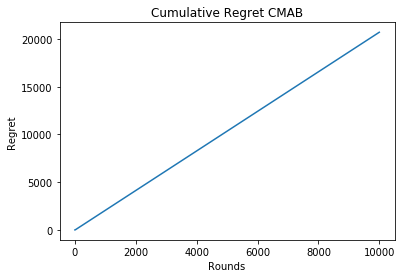

In [9]:
plt.plot(np.cumsum(regret))
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

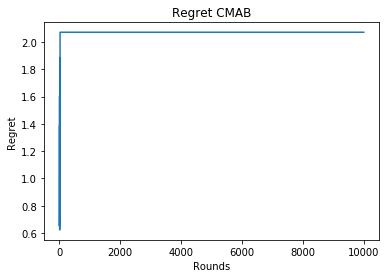

In [10]:
plt.plot(regret)
plt.title('Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Colliding Users')

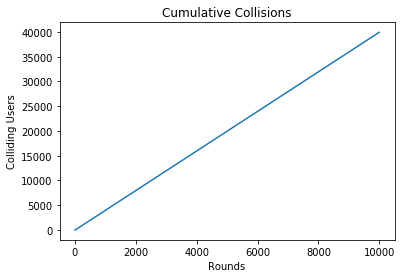

In [11]:
plt.plot(np.cumsum(collision_count))
plt.title('Cumulative Collisions')
plt.xlabel('Rounds')
plt.ylabel('Colliding Users')

Text(0, 0.5, 'Colliding Users')

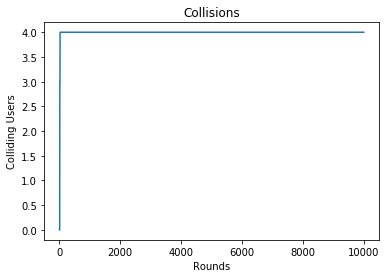

In [12]:
plt.plot(collision_count)
plt.title('Collisions')
plt.xlabel('Rounds')
plt.ylabel('Colliding Users')

In [13]:
regret[:10]

array([1.38203374, 0.65171227, 1.18694583, 0.73931798, 0.84739716,
       1.54989271, 1.6019736 , 0.93838882, 1.34926172, 0.62290603])

In [21]:
collision_count[-100:]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [22]:
get_user_locs(Users)

[4, 0, 1, 5]

In [23]:
arms

[4, 4, 1, 1]

In [24]:
optimal

([7, 4, 3, 6], 2.0719329849623898)

In [25]:
np.argmax(Users[0].ucb_raw)

8

In [26]:
Users[2].wait_times

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
svr_res

({0: None, 1: 2, 2: None, 3: None, 4: 0, 5: None, 6: None, 7: None, 8: None},
 {0: None,
  1: 2.0485138917033874,
  2: None,
  3: None,
  4: 1.8148919167261204,
  5: None,
  6: None,
  7: None,
  8: None},
 {0: None,
  1: 10.0,
  2: None,
  3: None,
  4: 9.0,
  5: None,
  6: None,
  7: None,
  8: None},
 {0: None,
  1: array([0.        , 0.64083465]),
  2: None,
  3: None,
  4: array([1.        , 0.64083465]),
  5: None,
  6: None,
  7: None,
  8: None},
 {0: False,
  1: True,
  2: False,
  3: False,
  4: True,
  5: False,
  6: False,
  7: False,
  8: False})